# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1155]:
# Подключаем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
# Время обучения модели
import timeit
from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
# import warnings

# Разбиение на обучающую, валидационную и тестовую выборку и кроссвалидация для повышения качеств обучения
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 

# и для машинного обучения разными способами (по условию мы выбираем линейную регрессию):
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [1156]:
# Уведомление о завершение работы определенного ячейка (очень пригодится для машинного обучения)
import jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


### Загрузим данные

In [1157]:
# Получаем датасет
try:
    # С локального файла
    try:
        df = pd.read_csv('autos.csv')
    except:
        df = pd.read_csv('/datasets/autos.csv')
except:
    print('Отсутствует датасет. Проверьте путь файла')

### Изучим данные

In [1158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Дополнительные информация:**

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [1159]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [1160]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Тут можно заметить странное, что в колонке "год регистрации автомобиля" есть 1000 и 9999. Скорее всего это аномальное значения. Также в данный момент не существуют машин, у которых мощностей двигателя больше 143 л.с. А также странно получилось, что машина выставлена в продажах бесплатно. Ну, может быть они хотят быстрее избавиться от них, а может "ради прикола" выставили в продажах, но все равно устраняем их

Text(0, 0.5, 'Стоимость ЕВРО')

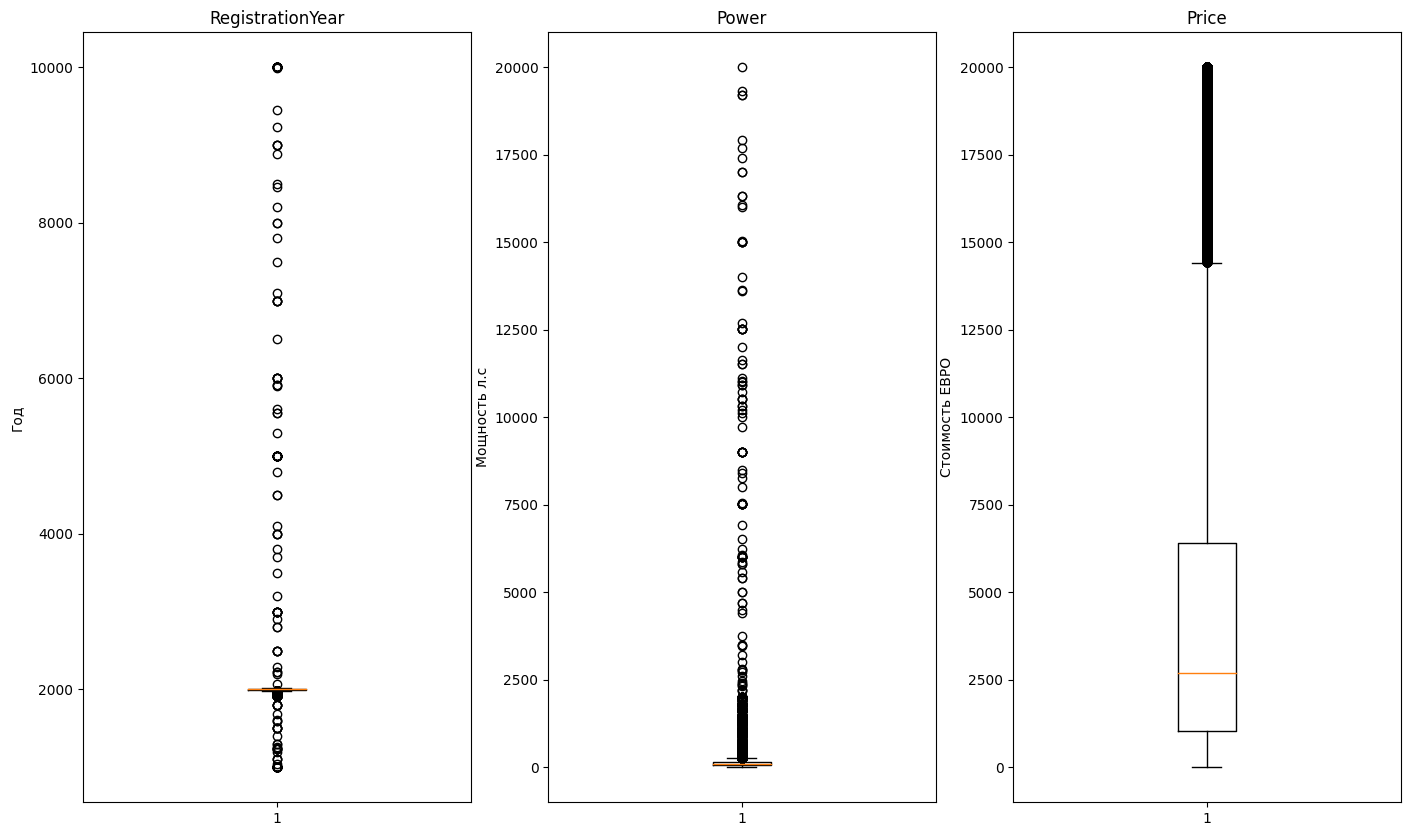

In [1161]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

### Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, то удалим их.

In [1162]:
# Скорпируем
df_clean = df.copy()

Удаляем аномальные значения

In [1163]:
df_clean = df.copy()
# Очистим
# Год регистрации автомобиля
df_clean = df[df['RegistrationYear'] > (df.describe()['RegistrationYear']['50%'] - df.describe()['RegistrationYear']['std'])]
df_clean = df_clean[df_clean['RegistrationYear'] < 2023]

In [1164]:
# Мощность двигателя л.с
df_clean = df_clean[df_clean['Power'] > abs(df_clean.describe()['Power']['50%'] - df_clean.describe()['Power']['std'])]
df_clean = df_clean[df_clean['Power'] < abs(df_clean.describe()['Power']['75%'] + df_clean.describe()['Power']['std'])]

In [1165]:
# Бесплатные автомобили и слишком дешевые автомобили
df_clean = df_clean[df_clean['Price'] > abs(df_clean.describe()['Price']['50%'] - df_clean.describe()['Price']['std'])]

In [1166]:
df_clean.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,202868.000000,202868.000000,202868.000000,202868.000000,202868.000000,202868.0,202868.000000
mean,6243.655318,2004.211334,143.444417,129597.447601,6.121646,0.0,52105.827829
std,4797.468519,6.343907,46.619757,35773.573448,3.540755,0.0,25906.456594
min,780.000000,1937.000000,85.000000,5000.000000,0.000000,0.0,1067.000000
25%,2399.000000,2000.000000,109.000000,125000.000000,3.000000,0.0,31552.000000
50%,4800.000000,2005.000000,136.000000,150000.000000,6.000000,0.0,51429.000000
75%,8990.000000,2008.000000,165.000000,150000.000000,9.000000,0.0,73066.000000
max,20000.000000,2019.000000,390.000000,150000.000000,12.000000,0.0,99998.000000


Text(0, 0.5, 'Стоимость ЕВРО')

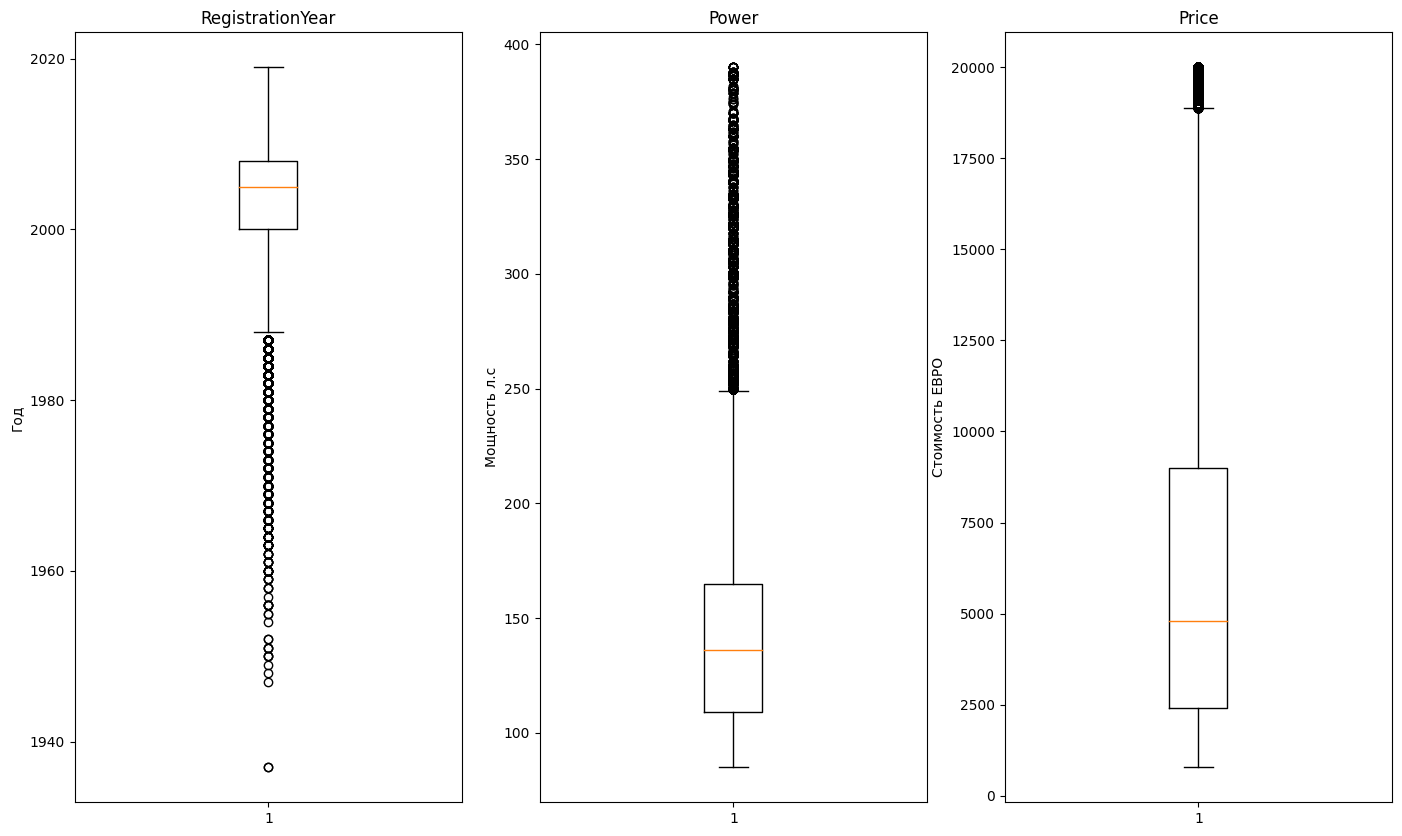

In [1167]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df_clean['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df_clean['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df_clean['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

In [1168]:
# Преобразуем на другой тип данных DateCrawled, DateCreated и LastSeen
df_clean['DateCrawled'] = pd.to_datetime(df_clean['DateCrawled'])
df_clean['DateCreated'] = pd.to_datetime(df_clean['DateCreated'])
df_clean['LastSeen'] = pd.to_datetime(df_clean['LastSeen'])

#### Пропущенные значения

Устранили аномальные значения, теперь смотрим кол-во пропущенных значений. Попробуем разбить 2 датасет, один из которых будет применять радикальным способом - устранять их насовсем. Второй - заполнение `"unknown"` или медиальным значением.

In [1169]:
df_clean.isna().sum()

DateCrawled              0
Price                    0
VehicleType          11090
RegistrationYear         0
Gearbox               2555
Power                    0
Model                 7150
Kilometer                0
RegistrationMonth        0
FuelType             10338
Brand                    0
Repaired             25729
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [1170]:
len(df_clean)

202868

##### Первый способ - радикальный

Тип автомобилей, коробки передачи, модели, топлива и состояния ремонта мы не можем поставить усредненные значения, т.к. это является уникальными. Но у нас достаточно информаций, чтобы можно устранять эти нежелательные пропуски

In [1171]:
# Скорпируем
df_clean_rad = df_clean.copy()

In [1172]:
# Устраняем
df_clean_rad = df_clean_rad[~df_clean_rad['VehicleType'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Gearbox'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Model'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['FuelType'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Repaired'].isna()]

In [1173]:
# Проверим
df_clean_rad.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [1174]:
# Сбрасываем и снова пронумерируем индексы
df_clean_rad = df_clean_rad.reset_index(drop=True)

In [1175]:
# Преобразуем на другой тип данных DateCrawled, DateCreated и LastSeen
df_clean_rad['DateCrawled'] = pd.to_datetime(df_clean_rad['DateCrawled'])
df_clean_rad['DateCreated'] = pd.to_datetime(df_clean_rad['DateCreated'])
df_clean_rad['LastSeen'] = pd.to_datetime(df_clean_rad['LastSeen'])

In [1176]:
df_clean_rad.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
1,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26,0,96224,2016-04-06 10:45:34
2,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07,0,57290,2016-04-07 10:25:17
3,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21,0,4177,2016-04-06 07:45:42
4,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11


In [1177]:
len(df_clean_rad)

162507

##### Второй способ - заполнение `"unknown"` или медианным значением 

In [1178]:
# Скорпируем датафрейм
df_clean_fill = df_clean.copy()

In [1179]:
# Заполним значением "unknown"
df_clean_fill['VehicleType'] = df_clean_fill['VehicleType'].fillna('unknown')
df_clean_fill['Gearbox'] = df_clean_fill['Gearbox'].fillna('unknown')
df_clean_fill['Model'] = df_clean_fill['Model'].fillna('unknown')
df_clean_fill['FuelType'] = df_clean_fill['FuelType'].fillna('unknown')
df_clean_fill['Repaired'] = df_clean_fill['Repaired'].fillna('unknown')

In [1180]:
# Проверим
df_clean_fill.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [1181]:
df_clean_fill.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,2016-03-17,0,27472,2016-03-31 17:17:06


In [1182]:
len(df_clean_fill)

202868

Теперь с данными в порядке, можно уже приступать к обучению моделей

## Обучение моделей первого датасета

Перед обучением нужно сделать следующие: прямое кодирование, порядкое кодирование и масштабируемость модели. Поэтому обучение моделей будет разделен на 3 этапа: OH, OHE, SCALER. А также обучение будет проводиться кроссвалидацией

Поскольку у нас присутствуют некоторые признаки, которые являются строковыми или ojbect типами, а для машинного обучения регрессионного типа требует числа. Поэтому примением кодировку, которая будет преобразовать в числа

In [1183]:
df_clean_rad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162507 entries, 0 to 162506
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        162507 non-null  datetime64[ns]
 1   Price              162507 non-null  int64         
 2   VehicleType        162507 non-null  object        
 3   RegistrationYear   162507 non-null  int64         
 4   Gearbox            162507 non-null  object        
 5   Power              162507 non-null  int64         
 6   Model              162507 non-null  object        
 7   Kilometer          162507 non-null  int64         
 8   RegistrationMonth  162507 non-null  int64         
 9   FuelType           162507 non-null  object        
 10  Brand              162507 non-null  object        
 11  Repaired           162507 non-null  object        
 12  DateCreated        162507 non-null  datetime64[ns]
 13  NumberOfPictures   162507 non-null  int64   

Как и видим, что существуют несколько признаков, имеющих типа object. Теперь создадим список, который автоматически заполняет определенный тип

In [1184]:
# Здесь будем сохранить результаты машинного обучения
results_rad = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

### Прямое кодирование - One-Hot Encoding

In [1185]:
# Убираем лишние признаки перед прямым кодированием
df_ohe = df_clean_rad[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']]

In [1186]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

In [1187]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,Repaired_yes
0,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2000,2004,105,150000,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2799,2005,140,150000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,17999,2011,190,70000,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7550,2007,136,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Деление на обучающей и валидационной выборки

In [1188]:
# Получаем признак и цель 
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

In [1189]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [1190]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 2, scoring = 'neg_root_mean_squared_error')

In [1191]:
%%notify -m "LinearRegression OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2615.507076605979
CPU times: total: 3.53 s
Wall time: 4.63 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1192]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6594.010577509967
CPU times: total: 62.5 ms
Wall time: 93.5 ms


In [1193]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### DecisionTreeRegressor

In [1194]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1195]:
%%notify -m "DecisionTreeRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3724.913236021877
CPU times: total: 4.2 s
Wall time: 4.24 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1196]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.8567741947145
CPU times: total: 78.1 ms
Wall time: 76 ms


In [1197]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### RandomForestRegressor

In [1198]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5], 'max_features': ['auto', 'log2'], 'n_estimators': [50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1199]:
%%notify -m "RandomForestRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 2538.408605279816
CPU times: total: 2min
Wall time: 2min 1s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1200]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6588.604644328343
CPU times: total: 203 ms
Wall time: 208 ms


In [1201]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### LightGBMRegressor

In [1202]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1203]:
%%notify -m "LightGBMRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2000.5614819609873
CPU times: total: 4min 30s
Wall time: 32.2 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1204]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6605.599306845436
CPU times: total: 1.28 s
Wall time: 141 ms


In [1205]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [1206]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1207]:
%%notify -m "CatBoostRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4846.9875114	total: 7.55ms	remaining: 68ms
1:	learn: 4814.7822695	total: 15ms	remaining: 59.9ms
2:	learn: 4783.1585938	total: 21.9ms	remaining: 51.2ms
3:	learn: 4751.5357796	total: 29.8ms	remaining: 44.7ms
4:	learn: 4720.5355666	total: 36.9ms	remaining: 36.9ms
5:	learn: 4689.5482800	total: 43.9ms	remaining: 29.3ms
6:	learn: 4659.1387398	total: 51.2ms	remaining: 22ms
7:	learn: 4629.5570054	total: 58.7ms	remaining: 14.7ms
8:	learn: 4600.2961044	total: 66ms	remaining: 7.34ms
9:	learn: 4571.1079682	total: 73.4ms	remaining: 0us
0:	learn: 4857.7084733	total: 6.89ms	remaining: 62ms
1:	learn: 4825.6369719	total: 14ms	remaining: 55.8ms
2:	learn: 4793.6930863	total: 20.7ms	remaining: 48.3ms
3:	learn: 4761.9419033	total: 28.1ms	remaining: 42.2ms
4:	learn: 4731.0998258	total: 35.2ms	remaining: 35.2ms
5:	learn: 4700.2584169	total: 42.7ms	remaining: 28.4ms
6:	learn: 4669.6469382	total: 50ms	remaining: 21.4ms
7:	learn: 4639.8234468	total: 57.4ms	remaining: 14.4ms
8:	learn: 4610.7007442	tota

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1208]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.062820178964
CPU times: total: 15.6 ms
Wall time: 26 ms


In [1209]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

### Порядковое кодирование - OrdinalEncoder

In [1210]:
col_type_obj = []

for i, name in enumerate(df_clean_rad.columns):
    if(df_clean_rad[name].dtype == object):
        print(i, name)
        col_type_obj.append(name)

print()
print('Список:', col_type_obj)

2 VehicleType
4 Gearbox
6 Model
9 FuelType
10 Brand
11 Repaired

Список: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


Теперь преобразуем в другой тип, применяя OrdinalEncoder

In [1211]:
df_mini_oe = pd.DataFrame(OrdinalEncoder().fit_transform(df_clean_rad[col_type_obj]), columns=col_type_obj)
df_mini_oe

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,1.0,1.0,8.0,6.0,25.0,0.0
1,4.0,1.0,10.0,6.0,19.0,0.0
2,7.0,1.0,164.0,2.0,36.0,1.0
3,6.0,1.0,153.0,2.0,23.0,0.0
4,0.0,1.0,58.0,2.0,10.0,0.0
...,...,...,...,...,...,...
162502,4.0,1.0,136.0,2.0,30.0,0.0
162503,4.0,1.0,112.0,2.0,36.0,0.0
162504,4.0,1.0,136.0,6.0,30.0,1.0
162505,1.0,0.0,102.0,6.0,32.0,0.0


Теперь создадим датасет, в котором содержатся исключительно цифры

In [1212]:
# Устраняем столбцы, в котором содержатся типы object
df_oe = df_clean_rad.drop(columns=col_type_obj)

# Сбросим индексы 
df_oe = df_oe.reset_index(drop=True)

# Добавим колонку в текущий датасет
df_oe = pd.concat([df_oe, df_mini_oe], axis=1)

In [1213]:
df_oe.head()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,2016-04-01 20:48:51,2200,2004,109,150000,8,2016-04-01,0,67112,2016-04-05 18:18:39,1.0,1.0,8.0,6.0,25.0,0.0
1,2016-03-26 19:54:18,2000,2004,105,150000,12,2016-03-26,0,96224,2016-04-06 10:45:34,4.0,1.0,10.0,6.0,19.0,0.0
2,2016-04-07 10:06:22,2799,2005,140,150000,12,2016-04-07,0,57290,2016-04-07 10:25:17,7.0,1.0,164.0,2.0,36.0,1.0
3,2016-03-21 12:57:01,17999,2011,190,70000,3,2016-03-21,0,4177,2016-04-06 07:45:42,6.0,1.0,153.0,2.0,23.0,0.0
4,2016-03-23 15:48:05,7550,2007,136,150000,6,2016-03-23,0,88361,2016-04-05 18:45:11,0.0,1.0,58.0,2.0,10.0,0.0


#### Деление на обучающей и валидационной выборки

In [1214]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [1215]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [1216]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1217]:
%%notify -m "LinearRegression OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3002.507156932004
CPU times: total: 62.5 ms
Wall time: 261 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1218]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6585.078575768656
CPU times: total: 0 ns
Wall time: 5.02 ms


In [1219]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### DecisionTreeRegressor

In [1220]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1221]:
%%notify -m "DecisionTreeRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3724.913236021877
CPU times: total: 422 ms
Wall time: 463 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1222]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.8567741947145
CPU times: total: 0 ns
Wall time: 5.99 ms


In [1223]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### RandomForestRegressor

In [1224]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1225]:
%%notify -m "RandomForestRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1785.8819591652598
CPU times: total: 2min 26s
Wall time: 2min 27s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1226]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6608.410008383504
CPU times: total: 484 ms
Wall time: 491 ms


In [1227]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### LightGBMRegressor

In [1228]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1229]:
%%notify -m "LightGBMRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2008.522255703379
CPU times: total: 1min 22s
Wall time: 5.9 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1230]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6605.167637210307
CPU times: total: 297 ms
Wall time: 20 ms


In [1231]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [1232]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1233]:
%%notify -m "CatBoostRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4846.6051479	total: 6.82ms	remaining: 61.3ms
1:	learn: 4814.5223218	total: 13.8ms	remaining: 55.1ms
2:	learn: 4782.9957624	total: 21.1ms	remaining: 49.1ms
3:	learn: 4751.6146319	total: 28ms	remaining: 42ms
4:	learn: 4720.6285867	total: 34.2ms	remaining: 34.2ms
5:	learn: 4690.0338599	total: 40.7ms	remaining: 27.1ms
6:	learn: 4659.5732740	total: 47.2ms	remaining: 20.2ms
7:	learn: 4630.0555759	total: 53.2ms	remaining: 13.3ms
8:	learn: 4600.4405503	total: 59.3ms	remaining: 6.58ms
9:	learn: 4571.1152711	total: 65.4ms	remaining: 0us
0:	learn: 4857.1058311	total: 5.95ms	remaining: 53.5ms
1:	learn: 4824.2113697	total: 12.4ms	remaining: 49.6ms
2:	learn: 4792.0538288	total: 18.7ms	remaining: 43.6ms
3:	learn: 4760.5799580	total: 25.3ms	remaining: 37.9ms
4:	learn: 4729.6262559	total: 32ms	remaining: 32ms
5:	learn: 4699.2374544	total: 39.2ms	remaining: 26.2ms
6:	learn: 4668.6303667	total: 45.5ms	remaining: 19.5ms
7:	learn: 4638.8373557	total: 51.5ms	remaining: 12.9ms
8:	learn: 4609.225797

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1234]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6593.05591004965
CPU times: total: 0 ns
Wall time: 12 ms


In [1235]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

### Масштабирование признаков - StandardScaler

#### Масштабируем OHE

##### Деление на обучающей и валидационной выборки

In [1236]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

In [1237]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [1238]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [1239]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(97504, 294)
(65003, 294)


In [1240]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,Repaired_yes
87084,-0.710156,-0.605848,0.599218,-0.087269,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
56075,-0.003565,-0.605848,0.599218,-0.671442,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72568,1.056321,0.560416,0.599218,-0.087269,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44154,-1.240099,-0.519458,0.599218,-0.087269,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
65982,0.173082,0.409234,0.599218,0.204818,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##### LinearRegression

In [1241]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1242]:
%%notify -m "LinearRegression OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 51547023542.16588
CPU times: total: 8.56 s
Wall time: 10.4 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1243]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6594.010577509499
CPU times: total: 62.5 ms
Wall time: 78.5 ms


In [1244]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### DecisionTreeRegressor

In [1245]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1246]:
%%notify -m "DecisionTreeRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3724.913236021877
CPU times: total: 4.36 s
Wall time: 4.37 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1247]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.8567741947145
CPU times: total: 78.1 ms
Wall time: 82.6 ms


In [1248]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### RandomForestRegressor

In [1249]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1250]:
%%notify -m "RandomForestRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1824.155239448041
CPU times: total: 10min 46s
Wall time: 10min 49s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1251]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6609.78310353503
CPU times: total: 625 ms
Wall time: 644 ms


In [1252]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### LightGBMRegressor

In [1253]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1254]:
%%notify -m "LightGBMRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2000.6264595258665
CPU times: total: 4min 42s
Wall time: 34.2 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1255]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6605.591586898953
CPU times: total: 1.03 s
Wall time: 169 ms


In [1256]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### CatBoostRegressor

In [1257]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1258]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4846.9875114	total: 7.5ms	remaining: 67.5ms
1:	learn: 4814.7822695	total: 14.6ms	remaining: 58.5ms
2:	learn: 4783.1585938	total: 21.6ms	remaining: 50.4ms
3:	learn: 4751.5357796	total: 29.3ms	remaining: 43.9ms
4:	learn: 4720.5355666	total: 36.5ms	remaining: 36.5ms
5:	learn: 4689.5482800	total: 44.1ms	remaining: 29.4ms
6:	learn: 4659.1387398	total: 51.4ms	remaining: 22ms
7:	learn: 4629.5570054	total: 58.8ms	remaining: 14.7ms
8:	learn: 4600.2961044	total: 65.8ms	remaining: 7.31ms
9:	learn: 4571.1079682	total: 72.7ms	remaining: 0us
0:	learn: 4857.7084733	total: 7.29ms	remaining: 65.6ms
1:	learn: 4825.6369719	total: 14.4ms	remaining: 57.6ms
2:	learn: 4793.6930863	total: 21.7ms	remaining: 50.6ms
3:	learn: 4761.9419033	total: 29.1ms	remaining: 43.6ms
4:	learn: 4731.0998258	total: 36.2ms	remaining: 36.2ms
5:	learn: 4700.2584169	total: 43.8ms	remaining: 29.2ms
6:	learn: 4669.6469382	total: 51.5ms	remaining: 22.1ms
7:	learn: 4639.8234468	total: 59ms	remaining: 14.8ms
8:	learn: 4610.700

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1259]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.062820178964
CPU times: total: 31.2 ms
Wall time: 26 ms


In [1260]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### Масштабируем OE

##### Деление на обучающей и валидационной выборки

In [1261]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [1262]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [1263]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [1264]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(97504, 12)
(65003, 12)


In [1265]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
87084,-0.710156,-0.605848,0.599218,-0.087269,0,45468,-0.048288,0.594613,0.182772,0.876679,1.359500,-0.287959
56075,-0.003565,-0.605848,0.599218,-0.671442,0,52134,1.226856,0.594613,0.684760,-1.156083,-0.619622,-0.287959
72568,1.056321,0.560416,0.599218,-0.087269,0,61138,1.226856,0.594613,-0.584153,-1.156083,0.141579,-0.287959
44154,-1.240099,-0.519458,0.599218,-0.087269,0,1979,1.226856,0.594613,0.503487,0.876679,1.131140,3.472713
65982,0.173082,0.409234,0.599218,0.204818,0,81829,-0.048288,0.594613,-1.225581,-1.156083,-1.228582,-0.287959


##### LinearRegression

In [1266]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1267]:
%%notify -m "LinearRegression OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3002.507156932
CPU times: total: 156 ms
Wall time: 274 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1268]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6585.078575768474
CPU times: total: 0 ns
Wall time: 10 ms


In [1269]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### DecisionTreeRegressor

In [1270]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1271]:
%%notify -m "DecisionTreeRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3724.913236021877
CPU times: total: 484 ms
Wall time: 488 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1272]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.8567741947145
CPU times: total: 0 ns
Wall time: 6.99 ms


In [1273]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### RandomForestRegressor

In [1274]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1275]:
%%notify -m "RandomForestRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1786.002708026132
CPU times: total: 2min 34s
Wall time: 2min 35s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1276]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6609.07559670751
CPU times: total: 516 ms
Wall time: 505 ms


In [1277]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### LightGBMRegressor

In [1278]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1279]:
%%notify -m "LightGBMRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2012.7004323791875
CPU times: total: 1min 22s
Wall time: 6.13 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1280]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6619.9737003853925
CPU times: total: 266 ms
Wall time: 17.5 ms


In [1281]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LightGBMRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [1282]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1283]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4846.6051479	total: 8.06ms	remaining: 72.5ms
1:	learn: 4814.5223218	total: 16.3ms	remaining: 65.3ms
2:	learn: 4782.9957624	total: 23.2ms	remaining: 54ms
3:	learn: 4751.6146319	total: 30.4ms	remaining: 45.6ms
4:	learn: 4720.6285867	total: 38ms	remaining: 38ms
5:	learn: 4690.0338599	total: 45.4ms	remaining: 30.3ms
6:	learn: 4659.5732740	total: 52.6ms	remaining: 22.5ms
7:	learn: 4630.0555759	total: 59.8ms	remaining: 14.9ms
8:	learn: 4600.4405503	total: 67.4ms	remaining: 7.49ms
9:	learn: 4571.1152711	total: 74.6ms	remaining: 0us
0:	learn: 4857.1058311	total: 7.43ms	remaining: 66.9ms
1:	learn: 4824.2113697	total: 14.1ms	remaining: 56.6ms
2:	learn: 4792.0538288	total: 20.9ms	remaining: 48.8ms
3:	learn: 4760.5799580	total: 27.8ms	remaining: 41.7ms
4:	learn: 4729.6262559	total: 34.7ms	remaining: 34.7ms
5:	learn: 4699.2374544	total: 41.9ms	remaining: 27.9ms
6:	learn: 4668.6303667	total: 48.9ms	remaining: 21ms
7:	learn: 4638.8373557	total: 56.2ms	remaining: 14ms
8:	learn: 4609.2257973	

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1284]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6593.05591004965
CPU times: total: 0 ns
Wall time: 7.99 ms


In [1285]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

## Обучение моделей второго датасета

In [1286]:
df_clean_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202868 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        202868 non-null  datetime64[ns]
 1   Price              202868 non-null  int64         
 2   VehicleType        202868 non-null  object        
 3   RegistrationYear   202868 non-null  int64         
 4   Gearbox            202868 non-null  object        
 5   Power              202868 non-null  int64         
 6   Model              202868 non-null  object        
 7   Kilometer          202868 non-null  int64         
 8   RegistrationMonth  202868 non-null  int64         
 9   FuelType           202868 non-null  object        
 10  Brand              202868 non-null  object        
 11  Repaired           202868 non-null  object        
 12  DateCreated        202868 non-null  datetime64[ns]
 13  NumberOfPictures   202868 non-null  int64   

In [1287]:
# Здесь будем сохранить результаты машинного обучения
results_fill = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

### Прямое кодирование - One-Hot Encoding

In [1288]:
# Убираем лишние признаки перед прямым кодированием
df_ohe = df_clean_fill[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']]

In [1289]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

In [1290]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14500,2014,125,30000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,999,1998,101,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


#### Деление на обучающей и валидационной выборки

In [1291]:
# Получаем признак и цель 
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

In [1292]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [1293]:
# Устанавливаем нужные параметры
parameters = {}
count_model = 0

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 2, scoring = 'neg_root_mean_squared_error')

In [1294]:
%%notify -m "LinearRegression OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2733.381267931969
CPU times: total: 5.62 s
Wall time: 6.59 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1295]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6229.0586191964285
CPU times: total: 109 ms
Wall time: 144 ms


In [1296]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### DecisionTreeRegressor

In [1297]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1298]:
%%notify -m "DecisionTreeRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3861.334204919407
CPU times: total: 6.11 s
Wall time: 6.13 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1299]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.566790590175
CPU times: total: 93.8 ms
Wall time: 107 ms


In [1300]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### RandomForestRegressor

In [1301]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5], 'max_features': ['auto', 'log2'], 'n_estimators': [50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1302]:
%%notify -m "RandomForestRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 2662.6548161258243
CPU times: total: 2min 54s
Wall time: 2min 55s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1303]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6235.28850771976
CPU times: total: 250 ms
Wall time: 249 ms


In [1304]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### LightGBMRegressor

In [1305]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1306]:
%%notify -m "LightGBMRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2087.8299704385126
CPU times: total: 5min 11s
Wall time: 42.8 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1307]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6239.510015213458
CPU times: total: 1.08 s
Wall time: 158 ms


In [1308]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [1309]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1310]:
%%notify -m "CatBoostRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4761.1754756	total: 8.93ms	remaining: 80.3ms
1:	learn: 4731.0875851	total: 17.1ms	remaining: 68.4ms
2:	learn: 4701.6877552	total: 25.3ms	remaining: 58.9ms
3:	learn: 4672.6865498	total: 33ms	remaining: 49.4ms
4:	learn: 4643.7221141	total: 41.1ms	remaining: 41.1ms
5:	learn: 4616.1460776	total: 48.4ms	remaining: 32.3ms
6:	learn: 4588.7492372	total: 56.1ms	remaining: 24ms
7:	learn: 4561.7183157	total: 64.2ms	remaining: 16.1ms
8:	learn: 4534.1246833	total: 72ms	remaining: 8ms
9:	learn: 4507.4579173	total: 79.9ms	remaining: 0us
0:	learn: 4759.3310431	total: 8.09ms	remaining: 72.8ms
1:	learn: 4729.3430931	total: 16.9ms	remaining: 67.5ms
2:	learn: 4699.7264591	total: 26.1ms	remaining: 60.9ms
3:	learn: 4670.7607846	total: 35.8ms	remaining: 53.6ms
4:	learn: 4641.8942240	total: 44.4ms	remaining: 44.4ms
5:	learn: 4613.6649656	total: 53.3ms	remaining: 35.5ms
6:	learn: 4586.3058030	total: 61.9ms	remaining: 26.5ms
7:	learn: 4560.0478706	total: 70.1ms	remaining: 17.5ms
8:	learn: 4533.2070735

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1311]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.68211036732
CPU times: total: 15.6 ms
Wall time: 24 ms


In [1312]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

### Порядковое кодирование - OrdinalEncoder

In [1313]:
df_mini_oe = pd.DataFrame(OrdinalEncoder().fit_transform(df_clean_fill[col_type_obj]), columns=col_type_obj)
df_mini_oe

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,2.0,1.0,218.0,2.0,1.0,2.0
1,6.0,0.0,113.0,2.0,14.0,1.0
2,1.0,1.0,8.0,6.0,25.0,0.0
3,0.0,1.0,58.0,6.0,10.0,1.0
4,5.0,1.0,112.0,7.0,38.0,1.0
...,...,...,...,...,...,...
202863,7.0,0.0,4.0,7.0,0.0,0.0
202864,4.0,1.0,136.0,6.0,30.0,2.0
202865,1.0,0.0,102.0,6.0,32.0,0.0
202866,0.0,1.0,214.0,2.0,38.0,0.0


Теперь создадим датасет, в котором содержатся исключительно цифры

In [1314]:
# Устраняем столбцы, в котором содержатся типы object
df_oe = df_clean_fill.drop(columns=col_type_obj)

# Сбросим индексы
df_oe = df_oe.reset_index(drop=True)

# Добавим колонку в текущий датасет
df_oe = pd.concat([df_oe, df_mini_oe], axis=1)

In [1315]:
df_oe.head()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,2016-03-24 10:58:45,18300,2011,190,125000,5,2016-03-24,0,66954,2016-04-07 01:46:50,2.0,1.0,218.0,2.0,1.0,2.0
1,2016-03-14 12:52:21,9800,2004,163,125000,8,2016-03-14,0,90480,2016-04-05 12:47:46,6.0,0.0,113.0,2.0,14.0,1.0
2,2016-04-01 20:48:51,2200,2004,109,150000,8,2016-04-01,0,67112,2016-04-05 18:18:39,1.0,1.0,8.0,6.0,25.0,0.0
3,2016-04-04 23:42:13,14500,2014,125,30000,8,2016-04-04,0,94505,2016-04-04 23:42:13,0.0,1.0,58.0,6.0,10.0,1.0
4,2016-03-17 10:53:50,999,1998,101,150000,0,2016-03-17,0,27472,2016-03-31 17:17:06,5.0,1.0,112.0,7.0,38.0,1.0


#### Деление на обучающей и валидационной выборки

In [1316]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [1317]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [1318]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1319]:
%%notify -m "LinearRegression OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3129.307316707223
CPU times: total: 141 ms
Wall time: 334 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1320]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.0771718836695
CPU times: total: 0 ns
Wall time: 6.54 ms


In [1321]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### DecisionTreeRegressor

In [1322]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1323]:
%%notify -m "DecisionTreeRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3861.334204919407
CPU times: total: 672 ms
Wall time: 676 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1324]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.566790590175
CPU times: total: 0 ns
Wall time: 8 ms


In [1325]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### RandomForestRegressor

In [1326]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1327]:
%%notify -m "RandomForestRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1859.9396861990529
CPU times: total: 3min 30s
Wall time: 3min 32s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1328]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6268.642680619235
CPU times: total: 594 ms
Wall time: 601 ms


In [1329]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### LightGBMRegressor

In [1330]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1331]:
%%notify -m "LightGBMRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2083.578196967768
CPU times: total: 1min 50s
Wall time: 7.97 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1332]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6243.651574354784
CPU times: total: 219 ms
Wall time: 25 ms


In [1333]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [1334]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1335]:
%%notify -m "CatBoostRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4762.3365469	total: 7.95ms	remaining: 71.5ms
1:	learn: 4733.1473781	total: 15.2ms	remaining: 60.8ms
2:	learn: 4704.5729801	total: 23.2ms	remaining: 54.2ms
3:	learn: 4677.0016001	total: 30.3ms	remaining: 45.4ms
4:	learn: 4648.2158587	total: 37.8ms	remaining: 37.8ms
5:	learn: 4620.2415181	total: 45.6ms	remaining: 30.4ms
6:	learn: 4592.3453749	total: 53.3ms	remaining: 22.8ms
7:	learn: 4564.8364035	total: 61.8ms	remaining: 15.4ms
8:	learn: 4538.3078806	total: 69.3ms	remaining: 7.7ms
9:	learn: 4512.3233957	total: 77.5ms	remaining: 0us
0:	learn: 4760.4678366	total: 24.9ms	remaining: 224ms
1:	learn: 4730.4803731	total: 32.3ms	remaining: 129ms
2:	learn: 4701.6330863	total: 39.1ms	remaining: 91.3ms
3:	learn: 4672.8719008	total: 46.2ms	remaining: 69.3ms
4:	learn: 4644.5956578	total: 53.6ms	remaining: 53.6ms
5:	learn: 4616.4925898	total: 60.7ms	remaining: 40.5ms
6:	learn: 4588.4033113	total: 67.7ms	remaining: 29ms
7:	learn: 4560.3700568	total: 75.7ms	remaining: 18.9ms
8:	learn: 4533.663

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1336]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6236.179723603107
CPU times: total: 0 ns
Wall time: 11 ms


In [1337]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

### Масштабирование признаков - StandardScaler

#### Масштабируем OHE

##### Деление на обучающей и валидационной выборки

In [1338]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

In [1339]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [1340]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [1341]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(121720, 302)
(81148, 302)


In [1342]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1197,0.282279,1.734882,0.570773,1.661342,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
38096,0.123983,-0.502838,0.570773,0.249475,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243558,-0.667499,-0.911653,0.570773,-1.727138,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,2.023540,-0.072507,0.570773,1.378969,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258624,-1.458982,1.046353,0.570773,1.378969,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


##### LinearRegression

In [1343]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1344]:
%%notify -m "LinearRegression OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2730.0913368364427
CPU times: total: 15.2 s
Wall time: 15 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1345]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6229.058619196202
CPU times: total: 93.8 ms
Wall time: 113 ms


In [1346]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### DecisionTreeRegressor

In [1347]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1348]:
%%notify -m "DecisionTreeRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3861.334204919407
CPU times: total: 6.42 s
Wall time: 6.43 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1349]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.566790590175
CPU times: total: 109 ms
Wall time: 119 ms


In [1350]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### RandomForestRegressor

In [1351]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1352]:
%%notify -m "RandomForestRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1884.5819383444207
CPU times: total: 13min 25s
Wall time: 13min 30s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1353]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6241.165821587537
CPU times: total: 766 ms
Wall time: 762 ms


In [1354]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### LightGBMRegressor

In [1355]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1356]:
%%notify -m "LightGBMRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2085.5063082398824
CPU times: total: 5min 24s
Wall time: 41.9 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1357]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6240.006870579051
CPU times: total: 1.36 s
Wall time: 173 ms


In [1358]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### CatBoostRegressor

In [1359]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1360]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4761.1754756	total: 7.76ms	remaining: 69.9ms
1:	learn: 4731.0875851	total: 15ms	remaining: 60ms
2:	learn: 4701.6877552	total: 22.6ms	remaining: 52.8ms
3:	learn: 4672.6865498	total: 30.7ms	remaining: 46.1ms
4:	learn: 4643.7221141	total: 38.3ms	remaining: 38.3ms
5:	learn: 4616.1460776	total: 45.4ms	remaining: 30.2ms
6:	learn: 4588.7492372	total: 53.7ms	remaining: 23ms
7:	learn: 4561.7183157	total: 61.4ms	remaining: 15.3ms
8:	learn: 4534.1246833	total: 69ms	remaining: 7.67ms
9:	learn: 4507.4579173	total: 76.3ms	remaining: 0us
0:	learn: 4759.3310431	total: 8.21ms	remaining: 73.9ms
1:	learn: 4729.3430931	total: 16.5ms	remaining: 66ms
2:	learn: 4699.7264591	total: 24.9ms	remaining: 58ms
3:	learn: 4670.7607846	total: 33ms	remaining: 49.4ms
4:	learn: 4641.8942240	total: 41ms	remaining: 41ms
5:	learn: 4613.6649656	total: 49.7ms	remaining: 33.2ms
6:	learn: 4586.3058030	total: 58.3ms	remaining: 25ms
7:	learn: 4560.0478706	total: 66.9ms	remaining: 16.7ms
8:	learn: 4533.2070735	total: 75.

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1361]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.68211036732
CPU times: total: 0 ns
Wall time: 25.5 ms


In [1362]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### Масштабируем OE

##### Деление на обучающей и валидационной выборки

In [1363]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [1364]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [1365]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [1366]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

(121720, 12)
(81148, 12)


In [1367]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
682,0.282279,1.734882,0.570773,1.661342,0,71065,-0.200386,-1.655115,-0.146434,-1.208137,0.094197,1.254420
21810,0.123983,-0.502838,0.570773,0.249475,0,51597,-1.694958,0.530849,1.849010,-1.208137,0.384253,-0.462159
139445,-0.667499,-0.911653,0.570773,-1.727138,0,53347,-1.694958,0.530849,1.849010,0.786944,0.384253,-0.462159
646,2.023540,-0.072507,0.570773,1.378969,0,12679,0.920542,0.530849,-1.171121,1.285714,0.021683,-0.462159
148038,-1.458982,1.046353,0.570773,1.378969,0,90766,-0.200386,0.530849,-0.618329,0.786944,0.094197,1.254420


##### LinearRegression

In [1368]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1369]:
%%notify -m "LinearRegression OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3129.307316707226
CPU times: total: 125 ms
Wall time: 321 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1370]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.077171883686
CPU times: total: 0 ns
Wall time: 10 ms


In [1371]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### DecisionTreeRegressor

In [1372]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1373]:
%%notify -m "DecisionTreeRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3861.334204919407
CPU times: total: 625 ms
Wall time: 669 ms


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1374]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6233.566790590175
CPU times: total: 0 ns
Wall time: 7.99 ms


In [1375]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### RandomForestRegressor

In [1376]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1377]:
%%notify -m "RandomForestRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Program File\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

RMSE: 1859.6035913080293
CPU times: total: 3min 24s
Wall time: 3min 25s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1378]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6267.836034974331
CPU times: total: 609 ms
Wall time: 609 ms


In [1379]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### LightGBMRegressor

In [1380]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1381]:
%%notify -m "LightGBMRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2084.859789414021
CPU times: total: 1min 47s
Wall time: 8.53 s


<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1382]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6243.74689592209
CPU times: total: 266 ms
Wall time: 26 ms


In [1383]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LightGBMRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [1384]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [1385]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4762.3365469	total: 8.05ms	remaining: 72.4ms
1:	learn: 4733.1473781	total: 15.7ms	remaining: 62.9ms
2:	learn: 4704.5729801	total: 40.4ms	remaining: 94.3ms
3:	learn: 4677.0016001	total: 48.7ms	remaining: 73ms
4:	learn: 4648.2158587	total: 56.8ms	remaining: 56.8ms
5:	learn: 4620.2415181	total: 64.4ms	remaining: 43ms
6:	learn: 4592.3453749	total: 72.7ms	remaining: 31.2ms
7:	learn: 4564.8364035	total: 80.8ms	remaining: 20.2ms
8:	learn: 4538.3078806	total: 89ms	remaining: 9.88ms
9:	learn: 4512.3233957	total: 97.6ms	remaining: 0us
0:	learn: 4760.4678366	total: 13.8ms	remaining: 124ms
1:	learn: 4730.4803731	total: 21.6ms	remaining: 86.2ms
2:	learn: 4701.6330863	total: 28.8ms	remaining: 67.2ms
3:	learn: 4672.8719008	total: 37.3ms	remaining: 55.9ms
4:	learn: 4644.5956578	total: 46.2ms	remaining: 46.2ms
5:	learn: 4616.4925898	total: 54.6ms	remaining: 36.4ms
6:	learn: 4588.4033113	total: 63.5ms	remaining: 27.2ms
7:	learn: 4560.3700568	total: 72ms	remaining: 18ms
8:	learn: 4533.6634738	t

<IPython.core.display.Javascript object>

**Проверка на тестовой выборки**

In [1386]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6236.179723603107
CPU times: total: 0 ns
Wall time: 11 ms


In [1387]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

## Анализ моделей

In [1388]:
%%notify -m "Total result"
results_rad = pd.DataFrame(results_rad).T
results_fill = pd.DataFrame(results_fill).T

<IPython.core.display.Javascript object>

### Первый результат

Попробуем устанавливать рейтинг. Критерии, которые важны заказчику: качество предсказания `RMSE`, время обучения модели `TIME TRAINING [s]` и время предсказания модели `TIME PREDICTION [s]`. Три параметры, значит будем рассматривать их вместе как 100%. Но качество предсказания будем устанавливать как 40%, а остальные по 30%.

In [1443]:
# Устанавливаем
results_rad['RATING'] = results_rad['RMSE'] * 0.4 * results_rad['TIME TRAINING [s]'] * 0.3 * results_rad['TIME PREDICTION [s]'] * 0.3

In [1462]:
# Сортируем по порядке убывания и смотрим
results_rad.sort_values(by='RATING', ascending=False)

,NAME,RMSE,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],RATING
10,LinearRegression_OHE_C,51547023542.165878,6594.010578,10.427,0.078,1509246127.043451
12,RandomForestRegressor_OHE_C,1824.155239,6609.783104,649.488,0.642,27382.333475
17,RandomForestRegressor_OE_C,1786.002708,6609.075597,155.345,0.504,5033.990941
7,RandomForestRegressor_OE,1785.881959,6608.410008,147.345,0.49,4641.803311
2,RandomForestRegressor_OHE,2538.408605,6588.604644,121.716,0.206,2291.284008
13,LGBMRegressor_OHE_C,2000.62646,6605.591587,34.25,0.169,416.88454
3,LGBMRegressor_OHE,2000.561482,6605.599307,32.25,0.14,325.171263
14,CatBoostRegressor_OHE_C,2230.285015,6592.06282,60.639,0.025,121.718028
4,CatBoostRegressor_OHE,2230.285015,6592.06282,59.647,0.025,119.726829
11,DecisionTreeRegressor_OHE_C,3724.913236,6592.856774,4.366,0.081,47.422824


Видно, что у модели `LinearRegression_OHE_C` появилось аномальное значение. Исключаем его 

Нам интересуют RMSE меньше `2500` и выберем `тройку лучших моделей`

In [1523]:
results_rad.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]

,NAME,RMSE,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],RATING
12,RandomForestRegressor_OHE_C,1824.155239,6609.783104,649.488,0.642,27382.333475
17,RandomForestRegressor_OE_C,1786.002708,6609.075597,155.345,0.504,5033.990941
7,RandomForestRegressor_OE,1785.881959,6608.410008,147.345,0.49,4641.803311


### Второй результат

Тоже опять устанавливаем рейтинг

In [1464]:
# Устанавливаем
results_fill['RATING'] = results_fill['RMSE'] * 0.4 * results_fill['TIME TRAINING [s]'] * 0.3 * results_fill['TIME PREDICTION [s]'] * 0.3

In [1465]:
# Сортируем по порядке убывания и смотрим
results_fill.sort_values(by='RATING', ascending=False)

,NAME,RMSE,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],RATING
12,RandomForestRegressor_OHE_C,1884.581938,6241.165822,810.87,0.761,41865.2236
7,RandomForestRegressor_OE,1859.939686,6268.642681,212.075,0.601,8534.248995
17,RandomForestRegressor_OE_C,1859.603591,6267.836035,205.792,0.609,8390.129373
2,RandomForestRegressor_OHE,2662.654816,6235.288508,175.141,0.248,4163.483762
13,LGBMRegressor_OHE_C,2085.506308,6240.006871,41.904,0.171,537.979343
3,LGBMRegressor_OHE,2087.82997,6239.510015,42.777,0.157,504.786352
10,LinearRegression_OHE_C,2730.091337,6229.058619,14.978,0.112,164.873754
14,CatBoostRegressor_OHE_C,2307.134556,6233.68211,68.966,0.024,137.474359
4,CatBoostRegressor_OHE,2307.134556,6233.68211,70.393,0.023,134.47227
11,DecisionTreeRegressor_OHE_C,3861.334205,6233.566791,6.435,0.117,104.658452


У предыдующего у модели `LinearRegression_OHE_C` есть аномальное значение. Здесь его нет 

Нам интересуют RMSE меньше `2500` и выберем `тройку лучших моделей`

In [1524]:
results_fill.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]

,NAME,RMSE,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],RATING
12,RandomForestRegressor_OHE_C,1884.581938,6241.165822,810.87,0.761,41865.2236
7,RandomForestRegressor_OE,1859.939686,6268.642681,212.075,0.601,8534.248995
17,RandomForestRegressor_OE_C,1859.603591,6267.836035,205.792,0.609,8390.129373


## Вывод

In [1526]:
pd.concat(
    [results_rad.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3], 
     results_fill.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]])

,NAME,RMSE,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],RATING
12,RandomForestRegressor_OHE_C,1824.155239,6609.783104,649.488,0.642,27382.333475
17,RandomForestRegressor_OE_C,1786.002708,6609.075597,155.345,0.504,5033.990941
7,RandomForestRegressor_OE,1785.881959,6608.410008,147.345,0.49,4641.803311
12,RandomForestRegressor_OHE_C,1884.581938,6241.165822,810.87,0.761,41865.2236
7,RandomForestRegressor_OE,1859.939686,6268.642681,212.075,0.601,8534.248995
17,RandomForestRegressor_OE_C,1859.603591,6267.836035,205.792,0.609,8390.129373


Первые три модели с радикального метода, а остальные с заполнением. Если рассмотреть качество модели, то они очень похожи. А что насчет время обучения, то у радикального метода модель `RandomForestRegressor_OE` самое короткое время на обучаемость по сравнению остальных - `147 секунда`, также время на предсказания

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Пока эта работа еще не поступила ревью, я немного подправил и изменил - сделал 2 датасеты, которые учитывает 2 варианта - радикальный способ и заполнение `"unknown"`. После проверки я узнаю, я на верном путем двигаюсь или нет.

В работе есть много дублирущие коды, после первой итерации я попробую оптимизировать- сделать цикличным способом
    
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей